In [112]:
!pip install torch-geometric
!pip install icecream

In [113]:
from torch_geometric.datasets import TUDataset
import torch_geometric.utils as tf_utils
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GINConv
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

In [114]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [115]:
dataset = TUDataset(".", "ENZYMES")
enzymes = convert_to_networkx(dataset)

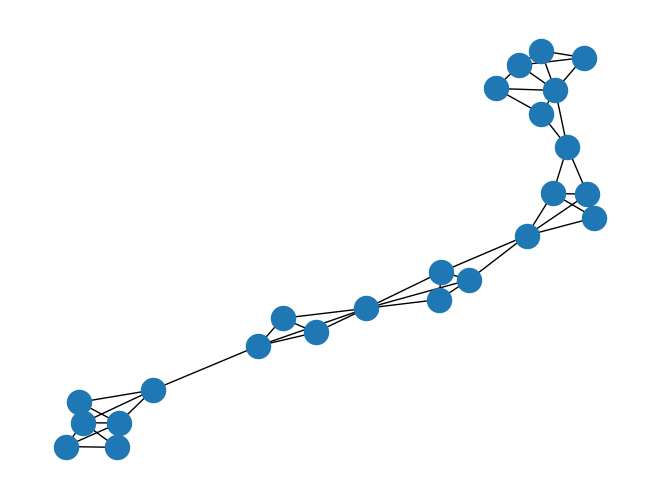

In [116]:
nx.draw(enzymes[5])

In [140]:
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
import torch_geometric.utils as tf_utils
import torch

from icecream import ic


DATASET = {'MUTAG': {'graphs': 188, 'features': 7, 'classes': 2},
           'ENZYMES': {'graphs': 600, 'features': 3, 'classes': 6},
           'PROTEINS': {'graphs': 1113, 'features': 3, 'classes': 2}}


class DataGraph():
    def __init__(self,
                 dataset_name: int,
                 mode: int) -> None:

        ic(dataset_name)
        assert dataset_name in DATASET.keys(), f"datasetname must be {list(DATASET.keys())} but is {dataset_name} "
        assert mode in ['train', 'val', 'test'], f"mode must be train, val or test but mode is {mode}"

        self.mode = mode
        dataset = TUDataset(root='data', name=dataset_name)
        self.data = self.convert_to_networkx(dataset)
        self.split_data()

        self.num_features = DATASET[dataset_name]['features']
        self.num_classes = DATASET[dataset_name]['classes']


    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int):
      g = self.data[index]

      # edge index
      edge_index = torch.tensor(list(g.edges)).t().contiguous()

      # nodes features
      nodes_features = []
      for i in range(nx.number_of_nodes(g)):
          nodes_features.append(g.nodes[i]['x'])
      nodes_features = torch.tensor(nodes_features)

      y = torch.tensor(g.graph["y"][0])
      y = torch.nn.functional.one_hot(y, num_classes=self.num_classes)
      # y = y.to(torch.float32)

      # Enveloppez nodes_features et edge_index dans un objet Data
      data = Data(x=nodes_features, edge_index=edge_index)

      return data, y


    def split_data(self):
        n = len(self.data)
        split1 = int(0.6 * n)
        split2 = int(0.8 * n)
        if self.mode == 'train':
            self.data = self.data[:split1]
        if self.mode == 'val':
            self.data = self.data[split1:split2]
        if self.mode == 'test':
            self.data = self.data[split2:]

    def convert_to_networkx(self, dataset):
        """
        Conversion des données PyTorch en graphes NetworkX
        :param dataset: le jeu de données PyTorch geometric
        :return: les graphes convertis
        """
        graphs = []
        for idx in range(len(dataset)):
            g = tf_utils.to_networkx(dataset[idx], node_attrs=["x"],
                                    to_undirected=True, graph_attrs=["y"])
            graphs.append(g)
        return graphs


if __name__ == '__main__':
    generator = DataGraph(dataset_name='ENZYMES', mode='train')
    ic(len(generator))
    f, e = generator.__getitem__(3)
    ic(f)
    ic(e)
    ic('ENZYMES' in DATASET.keys())

ic| dataset_name: 'ENZYMES'
ic| len(generator): 360
ic| f: Data(x=[24, 3], edge_index=[2, 45])
ic| e: tensor([0, 0, 0, 0, 0, 1])
ic| 'ENZYMES' in DATASET.keys(): True


In [141]:
import torch.nn as nn

# Définir un module de réseau de neurones personnalisé
class MyNNModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyNNModule, self).__init__()
        self.fc1 = nn.Linear(in_channels, 64)
        self.fc2 = nn.Linear(64, out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [142]:
my_nn_module = MyNNModule(3, 6)
conv = GINConv(nn=my_nn_module, eps=1e-15)

In [143]:
class MyModel(torch.nn.Module):
    def __init__(self, my_nn_module, epsilon):
        super(MyModel, self).__init__()
        self.conv1 = GINConv(my_nn_module, eps= epsilon)
        # Autres couches de votre modèle

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        # Autres opérations de votre modèle
        return x

In [144]:
# Instancier le modèle
model = MyModel(my_nn_module, 1e-15).to(device)
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Layer: conv1.nn.fc1.weight | Size: torch.Size([64, 3])
Layer: conv1.nn.fc1.bias | Size: torch.Size([64])
Layer: conv1.nn.fc2.weight | Size: torch.Size([6, 64])
Layer: conv1.nn.fc2.bias | Size: torch.Size([6])


In [145]:
training_generator = DataGraph(dataset_name='ENZYMES', mode='train')
validation_generator = DataGraph(dataset_name='ENZYMES', mode='val')
test_generator = DataGraph(dataset_name='ENZYMES', mode='test')

ic| dataset_name: 'ENZYMES'
ic| dataset_name: 'ENZYMES'
ic| dataset_name: 'ENZYMES'


In [150]:
def train():
  train = []
  val = []
  for epoch in range(40):  # Boucle sur les époques
    model.train()  # Mettre le modèle en mode d'entraînement
    running_loss = 0.0
    nbr = 0
    for idx in range(0, len(training_generator)): # Boucle sur la base
      (data, target) = training_generator.__getitem__(idx)
      data, target = data.to(device), target.to(device)  # Déplacer les données sur le dispositif
      optimizer.zero_grad()  # Réinitialiser les gradients
      output = model(data)  # Effectuer une passe avant
      loss = loss_function(output.unsqueeze(0), target.unsqueeze(0))  # Calculer la perte
      loss.backward()  # Effectuer une rétropropagation des gradients
      optimizer.step()  # Mettre à jour les poids
      running_loss += loss.item()
      nbr += 1
    print('[%d, %5d] loss: %.3f' % (epoch + 1, idx + 1, (running_loss / nbr)))
    train.append(running_loss / nbr)

    #Validation
    model.eval()
    total_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        for i in range(len(validation_generator)):
            data, target = validation_generator.__getitem__(i)
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_function(output.unsqueeze(0), target.unsqueeze(0))
            total_loss += loss.item()
            num_batches += 1
    print('Validation loss: %.3f' % (total_loss/num_batches))
    val.append(total_loss/num_batches)

  #Affichage
  plt.plot(train[2:])
  plt.plot(val[2:])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

[1,   360] loss: 1.438
Validation loss: 2.137
[2,   360] loss: 1.437
Validation loss: 2.138
[3,   360] loss: 1.438
Validation loss: 2.163
[4,   360] loss: 1.437
Validation loss: 2.190
[5,   360] loss: 1.436
Validation loss: 2.200
[6,   360] loss: 1.438
Validation loss: 2.212
[7,   360] loss: 1.437
Validation loss: 2.227
[8,   360] loss: 1.437
Validation loss: 2.233
[9,   360] loss: 1.437
Validation loss: 2.246
[10,   360] loss: 1.437
Validation loss: 2.248
[11,   360] loss: 1.435
Validation loss: 2.277
[12,   360] loss: 1.432
Validation loss: 2.302
[13,   360] loss: 1.436
Validation loss: 2.296
[14,   360] loss: 1.437
Validation loss: 2.299
[15,   360] loss: 1.435
Validation loss: 2.336
[16,   360] loss: 1.433
Validation loss: 2.360
[17,   360] loss: 1.435
Validation loss: 2.368
[18,   360] loss: 1.434
Validation loss: 2.388
[19,   360] loss: 1.433
Validation loss: 2.393
[20,   360] loss: 1.435
Validation loss: 2.441
[21,   360] loss: 1.434
Validation loss: 2.464
[22,   360] loss: 1.43

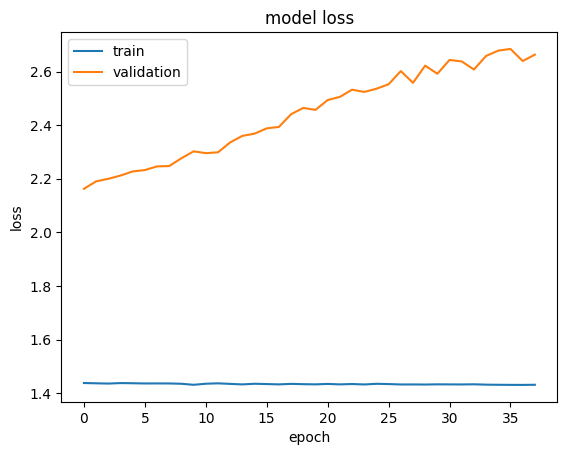

In [151]:
train()